# Data Preparation - Nova Iguaçu

This notebook extracts terrain proportions from neighborhood maps and decomposes
neighborhood-level OVT and ADT data into terrain-specific values using only two neighborhoods.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from scipy import optimize
from scipy.stats import pearsonr
import readHistData as hist

## 1. Load Observed Data from CSV

In [2]:
df = pd.read_csv('../data/NovaIguacu.csv')
print(f"Loaded {len(df)} rows of data")
df.head()

Loaded 12 rows of data


,ADT_Cabuçu,ADT_Ceramica,ADT_Moqueta,OVT_Cabuçu,OVT_Ceramica,OVT_Moqueta,month,mean_prec,mean_t_min,mean_t_med,mean_t_max
0,0.168421,0.326087,0.510204,15.192982,49.818182,29.067227,2011_07,2.900,15.853571,20.887500,25.921429
1,0.204082,0.204301,0.408163,19.504274,33.475000,28.336134,2011_08,4.175,17.128571,22.348214,27.567857
2,0.102041,0.134831,0.268041,14.373913,18.686441,28.512605,2011_09,5.475,17.639286,22.498214,27.357143
3,0.110000,0.180000,0.313131,17.775862,18.966102,32.474576,2011_10,9.075,18.321429,23.076786,27.832143
4,0.120000,0.280000,0.420000,68.707965,66.728070,59.823529,2011_11,2.675,18.760714,23.414286,28.067857


In [3]:
days = [i * 30 for i in range(len(df))]

CabucuOVT = df['OVT_Cabuçu'].ffill().bfill().values
MoquetaOVT = df['OVT_Moqueta'].ffill().bfill().values
CeramicaOVT = df['OVT_Ceramica'].ffill().bfill().values

CabucuADT = df['ADT_Cabuçu'].ffill().bfill().values
MoquetaADT = df['ADT_Moqueta'].ffill().bfill().values
CeramicaADT = df['ADT_Ceramica'].ffill().bfill().values

print(f"Days: {days[:5]}... to {days[-5:]}")
print(f"Number of time points: {len(days)}")

Days: [0, 30, 60, 90, 120]... to [210, 240, 270, 300, 330]
Number of time points: 12


In [4]:
import numpy as np
from scipy.stats import pearsonr

cities = {
    "Cabuçu": (CabucuADT, CabucuOVT),
    "Moqueta": (MoquetaADT, MoquetaOVT),
    "Ceramica": (CeramicaADT, CeramicaOVT),
}

results = {}
for name, (adt, ovt) in cities.items():
    r, p = pearsonr(adt, ovt)
    print(f"{name}: Pearson r = {r:.4f}, p-value = {p:.4g}")

Cabuçu: Pearson r = 0.4581, p-value = 0.1342
Moqueta: Pearson r = 0.3477, p-value = 0.2681
Ceramica: Pearson r = 0.4272, p-value = 0.1661


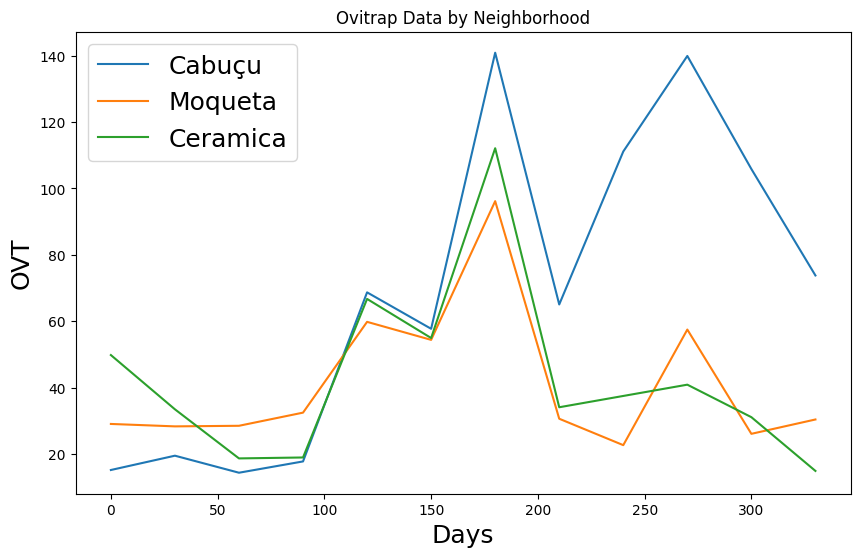

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(days, CabucuOVT, label='Cabuçu')
plt.plot(days, MoquetaOVT, label='Moqueta')
plt.plot(days, CeramicaOVT, label='Ceramica')
plt.legend(fontsize=18)
plt.xlabel("Days", fontsize=18)
plt.ylabel("OVT", fontsize=18)
plt.title("Ovitrap Data by Neighborhood")
plt.show()

## 2. Extract Terrain Proportions from Maps (use only two neighborhoods)

In [6]:
def isGreen(rgb):
    r, g, b = rgb
    if g > r and g > b and g > 50:
        return True
    if g > 40 and g > r * 0.9 and g > b * 1.1:
        return True
    return False

def isStreet(rgb_map):
    r, g, b = rgb_map
    if b > r and 200 < b < 245 and 200 < g < 235:
        if abs(r - g) < 30:
            return True
    return False

def isWater(rgb_map):
    r, g, b = rgb_map
    if b > 200 and b > r + 50 and b > g + 30:
        return True
    return False

def count_terrain_from_images(roadmap_path, satellite_path):
    roadmap = Image.open(roadmap_path).convert('RGB')
    satellite = Image.open(satellite_path).convert('RGB')
    width, height = roadmap.size
    if satellite.size != (width, height):
        satellite = satellite.resize((width, height))
    water, parks, streets, houses = 0, 0, 0, 0
    step = 3
    for x in range(0, width, step):
        for y in range(0, height, step):
            pixel_map = roadmap.getpixel((x, y))[:3]
            pixel_sat = satellite.getpixel((x, y))[:3]
            if isWater(pixel_map):
                water += 1
            elif isStreet(pixel_map):
                streets += 1
            elif isGreen(pixel_sat):
                parks += 1
            else:
                houses += 1
    return [water, parks, streets, houses]

In [7]:
neighborhoods = ['Cabucu', 'Ceramica'] #Moqueta removed
map_base_path = '../maps/NovaIguacu_RJ'

proportions_raw = []
for neighborhood in neighborhoods:
    roadmap_path = f"{map_base_path}/{neighborhood}/roadmap.png"
    satellite_path = f"{map_base_path}/{neighborhood}/satellite.png"
    print(f"Processing {neighborhood}...")
    counts = count_terrain_from_images(roadmap_path, satellite_path)
    print(f"  Raw counts [water, parks, streets, houses]: {counts}")
    proportions_raw.append(counts)

Processing Cabucu...
  Raw counts [water, parks, streets, houses]: [0, 22095, 24422, 135812]
Processing Ceramica...
  Raw counts [water, parks, streets, houses]: [0, 7778, 31218, 143333]


In [8]:
proportions = [np.array(c) / sum(c) for c in proportions_raw]
matProporcoes = np.matrix(proportions)

print("Proportions [water, parks, streets, houses]:")
for name, props in zip(neighborhoods, proportions):
    print(f"  {name}: water={props[0]:.4f}, parks={props[1]:.4f}, streets={props[2]:.4f}, houses={props[3]:.4f}")
print("\nProportions Matrix:")
print(matProporcoes)

Proportions [water, parks, streets, houses]:
  Cabucu: water=0.0000, parks=0.1212, streets=0.1339, houses=0.7449
  Ceramica: water=0.0000, parks=0.0427, streets=0.1712, houses=0.7861

Proportions Matrix:
[[0.         0.12118204 0.13394468 0.74487328]
 [0.         0.04265915 0.17121796 0.78612289]]


## 3. Decompose OVT Data

In [9]:
O_agua, O_parque, O_rua, O_casa = [], [], [], []
OVT_data = [CabucuOVT, CeramicaOVT]

for t in range(len(days)):
    vetOvo = [OVT_data[i][t] for i in range(2)]
    def f(x):
        return np.linalg.norm(matProporcoes @ x - vetOvo)
    result = optimize.minimize(f, [0, 0, 0, 0], bounds=[(0, None)]*4)
    O_agua.append(result.x[0])
    O_parque.append(result.x[1])
    O_rua.append(result.x[2])
    O_casa.append(result.x[3])

O_agua, O_parque, O_rua, O_casa = np.array(O_agua), np.array(O_parque), np.array(O_rua), np.array(O_casa)
print("OVT decomposition complete.")

OVT decomposition complete.


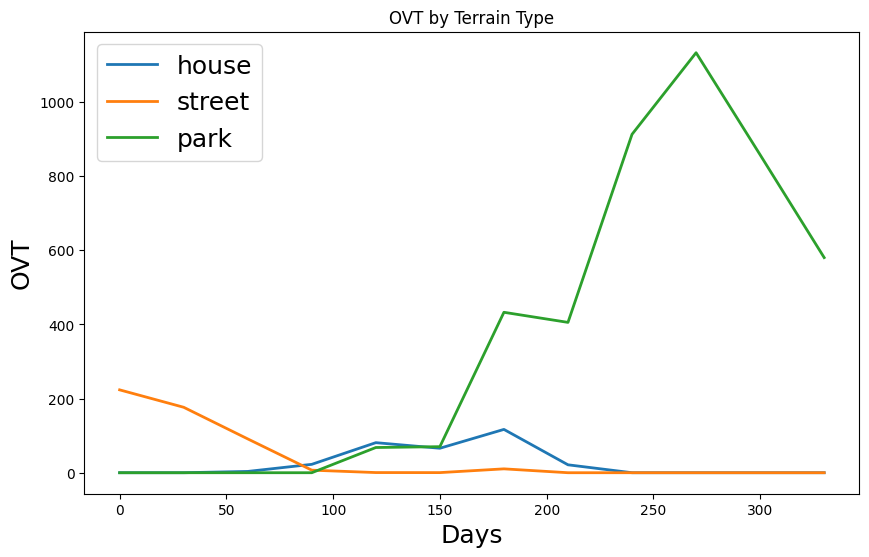

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(days, O_casa, label="house", linewidth=2)
plt.plot(days, O_rua, label="street", linewidth=2)
plt.plot(days, O_parque, label="park", linewidth=2)
plt.legend(fontsize=18)
plt.xlabel("Days", fontsize=18)
plt.ylabel("OVT", fontsize=18)
plt.title("OVT by Terrain Type")
plt.show()

## 4. Decompose ADT Data

In [11]:
ADT_agua, ADT_parque, ADT_rua, ADT_casa = [], [], [], []
ADT_data = [CabucuADT, CeramicaADT]

for t in range(len(days)):
    vetAdt = [ADT_data[i][t] for i in range(2)]
    def f(x):
        return np.linalg.norm(matProporcoes @ x - vetAdt)
    result = optimize.minimize(f, [0, 0, 0, 0], bounds=[(0, None)]*4)
    ADT_agua.append(result.x[0])
    ADT_parque.append(result.x[1])
    ADT_rua.append(result.x[2])
    ADT_casa.append(result.x[3])

ADT_agua, ADT_parque, ADT_rua, ADT_casa = np.array(ADT_agua), np.array(ADT_parque), np.array(ADT_rua), np.array(ADT_casa)
print("ADT decomposition complete.")

ADT decomposition complete.


## 5. Validate Reconstruction

In [12]:
reconstructed_OVT = [np.zeros(len(days)) for _ in range(2)]
for t in range(len(days)):
    R = matProporcoes @ [O_agua[t], O_parque[t], O_rua[t], O_casa[t]]
    for i in range(2):
        reconstructed_OVT[i][t] = R[0, i]

print("Reconstruction Correlations (OVT):")
for i, name in enumerate(neighborhoods):
    corr = pearsonr(reconstructed_OVT[i], OVT_data[i])[0]
    print(f"  {name}: {corr:.4f}")

Reconstruction Correlations (OVT):
  Cabucu: 0.9960
  Ceramica: 0.9793


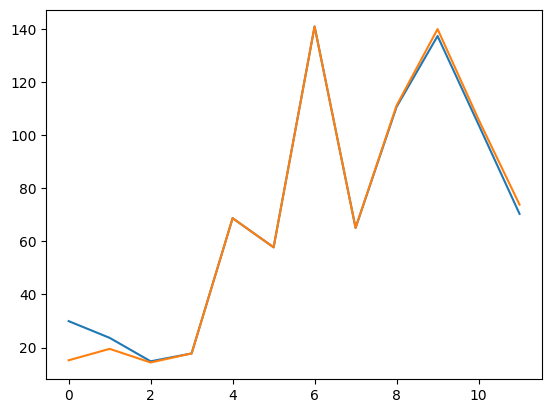

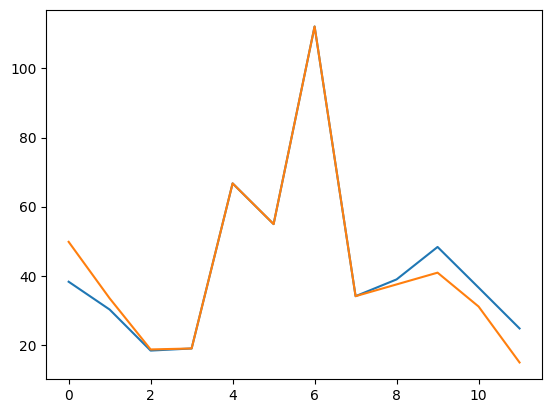

In [13]:
#plot reconstructed OVT and real OVT
plt.plot(reconstructed_OVT[0])
plt.plot(OVT_data[0])
plt.show()
plt.plot(reconstructed_OVT[1])
plt.plot(OVT_data[1])
plt.show()

In [14]:
reconstructed_ADT = [np.zeros(len(days)) for _ in range(2)]
for t in range(len(days)):
    R = matProporcoes @ [ADT_agua[t], ADT_parque[t], ADT_rua[t], ADT_casa[t]]
    for i in range(2):
        reconstructed_ADT[i][t] = R[0, i]

print("Reconstruction Correlations (ADT):")
for i, name in enumerate(neighborhoods):
    corr = pearsonr(reconstructed_ADT[i], ADT_data[i])[0]
    print(f"  {name}: {corr:.4f}")

Reconstruction Correlations (ADT):
  Cabucu: 0.9502
  Ceramica: 0.8914


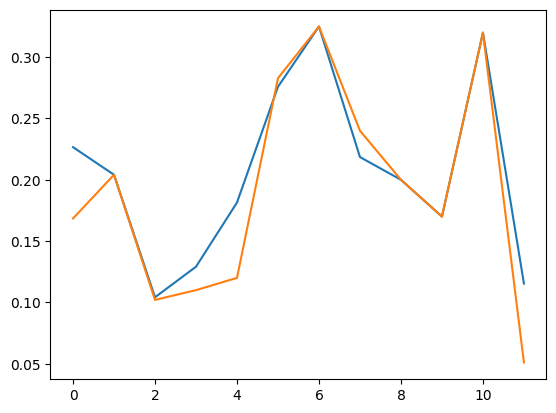

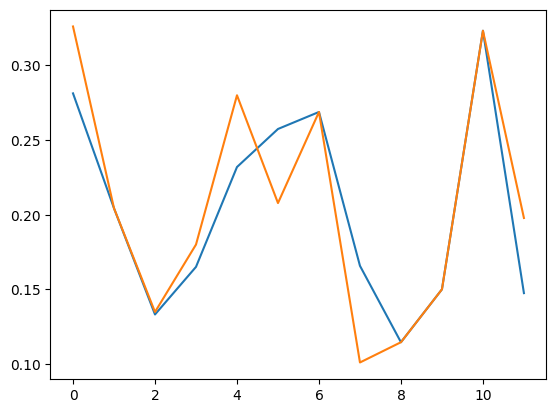

In [15]:
#plot reconstructed ADT and real ADT
plt.plot(reconstructed_ADT[0])
plt.plot(ADT_data[0])
plt.show()
plt.plot(reconstructed_ADT[1])
plt.plot(ADT_data[1])
plt.show()

## Check with Moqueta

Processing Moqueta...
  Raw counts [water, parks, streets, houses]: [0, 15480, 22603, 144246]


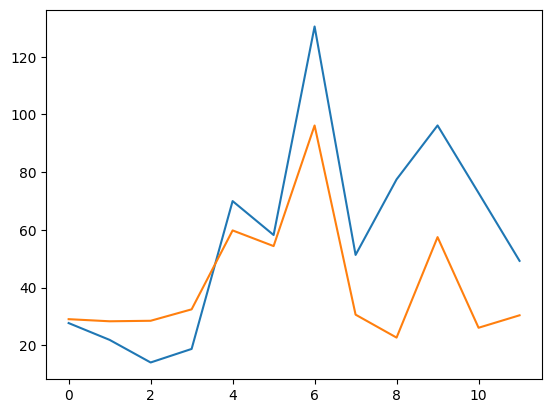

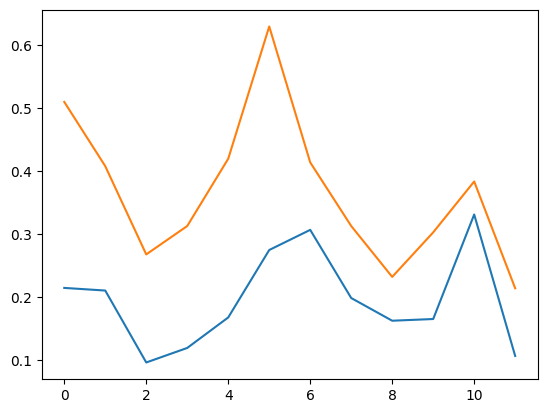

pearson OVT: 0.7431036993847931
pearson ADT: 0.6365621304394141


In [16]:
neighborhoods = ['Moqueta'] #Moqueta only
map_base_path = '../maps/NovaIguacu_RJ'

proportions_raw = []
for neighborhood in neighborhoods:
    roadmap_path = f"{map_base_path}/{neighborhood}/roadmap.png"
    satellite_path = f"{map_base_path}/{neighborhood}/satellite.png"
    print(f"Processing {neighborhood}...")
    counts = count_terrain_from_images(roadmap_path, satellite_path)
    print(f"  Raw counts [water, parks, streets, houses]: {counts}")
    proportions_raw.append(counts)

proportions = [np.array(c) / sum(c) for c in proportions_raw]
matProporcoes = np.matrix(proportions)

reconstructed_ADT = np.zeros(len(days))
for t in range(len(days)):
    R = matProporcoes @ [ADT_agua[t], ADT_parque[t], ADT_rua[t], ADT_casa[t]]
    reconstructed_ADT[t] = R[0, 0]  # Only water and parks

reconstructed_OVT = np.zeros(len(days))
for t in range(len(days)):
    R = matProporcoes @ [O_agua[t], O_parque[t], O_rua[t], O_casa[t]]
    reconstructed_OVT[t] = R[0, 0]


plt.plot(reconstructed_OVT)
plt.plot(MoquetaOVT)
plt.show()
plt.plot(reconstructed_ADT)
plt.plot(MoquetaADT)
plt.show()

print('pearson OVT:', np.corrcoef(reconstructed_OVT, MoquetaOVT)[0, 1])
print('pearson ADT:', np.corrcoef(reconstructed_ADT, MoquetaADT)[0, 1])

## 6. Compact Results

In [17]:
full_data = {
    "Day": days,
    "OVT_house": np.array(O_casa),
    "OVT_park": np.array(O_parque),
    "OVT_street": np.array(O_rua),
    "ADT_house": np.array(ADT_casa),
    "ADT_park": np.array(ADT_parque),
    "ADT_street": np.array(ADT_rua),
    "Temperature": np.array([hist.temperature(t) for t in days]),
    "Pluviosity": np.array([hist.pluviosity(t) for t in days])
}

# Data fitting
Now we fit with this values from 2 neighborhoods and test with the third

In [18]:
import numpy as np
import pandas as pd
import json
import os
import lmfit
from scipy.special import erf
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt

#Neighborhoods to train on
NEIGHBORHOODS = ['Cabucu', 'Ceramica']

## 1. Helper Functions
Functions from `readHistData.py` directly implemented here for portability.

In [19]:
def normal(R, mu, T):
    return np.exp(-(T-mu)**2/(2*R))

def plateau(R, mu, T):
    # Note: The original code used 2*R**5 which allows R to be negative if odd, but R is usually width.
    # Assuming R is positive squared or absolute width.
    return np.exp(-(T-mu)**8/(2*R)**5)

def phi(P):
    return (erf((P-10)/40) + 0.3)/1.2


temperature = hist.temperature
pluviosity = hist.pluviosity

## 2. Model definition

In [20]:
def calculate_model(params, T_arr, P_arr):
    # Extract parameters
    Tminmu = params["Tminmu"].value
    Tmaxmu = params["Tmaxmu"].value
    Tmingamma = params["Tmingamma"].value
    Tmaxgamma = params["Tmaxgamma"].value
    Tminr = params["Tminr"].value
    Tmaxr = params["Tmaxr"].value
    Tmink = params["Tmink"].value
    Tmaxk = params["Tmaxk"].value
    Tmine = params["Tmine"].value
    Tmaxe = params["Tmaxe"].value
    mu_factor = params["mu_factor"].value
    
    # Constants
    mu10 = 0.1170
    mu20 = 0.025
    mu30 = 0.01
    gamma0 = 0.5596
    r0 = 34
    k0 = 89000
    e0 = 0.24
    
    # Vectorized Calculation
    Mmu = (Tminmu + Tmaxmu) / 2
    Dmu = abs((Tmaxmu - Tminmu )) / 2
    Mgamma = (Tmingamma + Tmaxgamma) / 2
    Dgamma = abs((Tmaxgamma - Tmingamma)) / 2
    Mr = (Tminr + Tmaxr) / 2
    Dr = abs((Tmaxr - Tminr)) / 2
    Mk = (Tmink + Tmaxk) / 2
    Dk = abs((Tmaxk - Tmink)) / 2
    Me = (Tmine + Tmaxe) / 2
    De = abs((Tmaxe - Tmine)) / 2

    mu1 = (mu_factor - (mu_factor-1)*plateau(Dmu, Mmu, T_arr))*mu10
    mu2 = (mu_factor - (mu_factor-1)*plateau(Dmu, Mmu, T_arr))*mu20
    mu3 = (mu_factor - (mu_factor-1)*plateau(Dmu, Mmu, T_arr))*mu30
    gamma = normal(Dgamma,Mgamma,T_arr)*gamma0
    r = phi(P_arr)*normal(Dr,Mr,T_arr)*r0
    k = phi(P_arr)*normal(Dk,Mk,T_arr)*k0
    e = e0*normal(De,Me,T_arr)*phi(P_arr)
    
    denominator_q0 = mu1 * (mu2 + gamma) * (mu3 + e)
    # Avoid division by zero
    Q0 = np.zeros_like(T_arr)
    valid_q0 = denominator_q0 != 0
    Q0[valid_q0] = (gamma[valid_q0] * e[valid_q0] * r[valid_q0]) / denominator_q0[valid_q0]

    eqADT = np.zeros_like(T_arr)
    eqOVT = np.zeros_like(T_arr)
    
    # Condition Q0 > 1
    cond = Q0 > 1
    
    if np.any(cond):
        eqADT[cond] = k[cond] * (gamma[cond] / mu1[cond]) * (1 - 1 / Q0[cond])
        
        denom_ovt = mu1 * (mu3 + e)
        valid_ovt = (denom_ovt != 0) & cond
        eqOVT[valid_ovt] = k[valid_ovt] * (gamma[valid_ovt] * r[valid_ovt]) / denom_ovt[valid_ovt] * (1 - 1 / Q0[valid_ovt])
        
    return eqOVT, eqADT

def objective_function(params, category):
    # category is 'park', 'street', or 'house'
    ovt_col = f'OVT_{category}'
    adt_col = f'ADT_{category}'
    
    T_arr = full_data['Temperature']
    P_arr = full_data['Pluviosity']
    
    ovt_obs = full_data[ovt_col]
    adt_obs = full_data[adt_col]
    
    ovt_pred, adt_pred = calculate_model(params, T_arr, P_arr)
    
    # Normalize residuals by std dev
    ovt_std = np.std(ovt_obs) + 1e-8
    adt_std = np.std(adt_obs) + 1e-8
    
    resid_ovt = (ovt_obs - ovt_pred) / ovt_std
    resid_adt = (adt_obs - adt_pred) / adt_std
    
 
    return np.concatenate((resid_ovt, resid_adt))

## 3. Sensitivity analysis and setup

In [21]:
# Parameter Definitions
TMIN = 0
TMAX = 40

param_names = [
    "Tminmu", "fraction_mu",
    "Tmingamma", "fraction_gamma",
    "Tminr", "fraction_r",
    "Tmink", "fraction_k",
    "Tmine", "fraction_e",
    "mu_factor"
]

problem = {
    'num_vars': len(param_names),
    'names': param_names,
    'bounds': [[TMIN, TMAX], [0.1, 1.0]] * 5 + [[1.0, 10.0]]
}

# Wrapper for sensitivity analysis
def sensitivity_wrapper(X):
   
    # Pre-create params object to update in loop
    p = lmfit.Parameters()
    for name in param_names:
        p.add(name, value=0)
        if "fraction" in name:
            target_tmin = name.replace("fraction_", "Tmin")
            target_tmax = name.replace("fraction_", "Tmax")
                
            p.add(target_tmax, expr=f"{target_tmin} + {name} * ({TMAX} - {target_tmin})")
            
    out = np.zeros(X.shape[0])
    
    for i, x in enumerate(X):
        p["Tminmu"].value = x[0]
        p["fraction_mu"].value = x[1]
        
        p["Tmingamma"].value = x[2]
        p["fraction_gamma"].value = x[3]
        
        p["Tminr"].value = x[4]
        p["fraction_r"].value = x[5]
        
        p["Tmink"].value = x[6]
        p["fraction_k"].value = x[7]
        
        p["Tmine"].value = x[8]
        p["fraction_e"].value = x[9]
        
        p["mu_factor"].value = x[10]

        # Calculate residuals
        eqOVT,eqADT = calculate_model(p, full_data['Temperature'], full_data['Pluviosity'])
        out[i] = np.sum(np.concatenate([eqOVT, eqADT])**2)
        
    return out

In [22]:


def create_params(sensible_params):
    params = lmfit.Parameters()
    # Defaults
    defaults = {
        "Tminmu": (TMIN+TMAX)/2, "fraction_mu": 0.5,
        "Tmingamma": (TMIN+TMAX)/2, "fraction_gamma": 0.5,
        "Tminr": (TMIN+TMAX)/2, "fraction_r": 0.5,
        "Tmink": (TMIN+TMAX)/2, "fraction_k": 0.5,
        "Tmine": (TMIN+TMAX)/2, "fraction_e": 0.5,
        "mu_factor": 5.0
    }
    
    for name in param_names:
        val = defaults.get(name, (TMIN+TMAX)/2)
        vary = name in sensible_params                
        range_min = TMIN if "Tmin" in name else 0.1
        range_max = TMAX if "Tmin" in name else 1.0
        if name == "mu_factor":
            range_min = 1.0
            range_max = 10.0
        params.add(name, value=val, min=range_min, max=range_max, vary=vary)
        
    # Add Tmax expressions
    params.add("Tmaxmu", expr=f"Tminmu + fraction_mu * ({TMAX} - Tminmu)")
    params.add("Tmaxgamma", expr=f"Tmingamma + fraction_gamma * ({TMAX} - Tmingamma)")
    params.add("Tmaxr", expr=f"Tminr + fraction_r * ({TMAX} - Tminr)")
    params.add("Tmaxk", expr=f"Tmink + fraction_k * ({TMAX} - Tmink)")
    params.add("Tmaxe", expr=f"Tmine + fraction_e * ({TMAX} - Tmine)")
    
    
    return params

## 4. Training loop

In [23]:
print("Performing Sensitivity Analysis...")
param_values = saltelli.sample(problem, 1024*8)
Y = sensitivity_wrapper(param_values)
Si = sobol.analyze(problem, Y, print_to_console=False)

Performing Sensitivity Analysis...


/var/folders/_c/wqlz16pj5530wg9sb_zqc_lr0000gp/T/ipykernel_92683/193820017.py:2: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024*8)
/opt/homebrew/lib/python3.13/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [24]:
print(Si)

{'S1': array([ 1.86161097e-04,  2.99384156e-04,  3.03680863e-04, -1.16000715e-05,
        1.02723655e-03,  1.90834637e-04,  5.45760217e-04, -3.54893787e-04,
        3.58760626e-04,  3.19967415e-04,  1.55685897e-04]), 'S1_conf': array([0.00046424, 0.00049658, 0.00068153, 0.00049939, 0.00132846,
       0.0004699 , 0.0005345 , 0.00068586, 0.00072713, 0.00045727,
       0.00023569]), 'ST': array([0.14450285, 0.2662707 , 0.42964742, 0.26639716, 0.47202154,
       0.20568757, 0.37332967, 0.46133744, 0.47181833, 0.26667537,
       0.03617056]), 'ST_conf': array([0.1776603 , 0.21367722, 0.39797609, 0.30041086, 0.43284177,
       0.19976495, 0.29123887, 0.71398144, 0.4059256 , 0.23863965,
       0.05728422]), 'S2': array([[            nan,  2.84727922e-04,  2.87937572e-04,
         2.79471715e-04, -5.93067494e-05,  2.47327358e-04,
         2.65410416e-04,  2.75231943e-04,  2.77971371e-04,
         2.82458567e-04,  2.85199867e-04],
       [            nan,             nan, -4.68452741e-04,
     

Sensible parameters: ['Tminr', 'Tmine', 'fraction_k', 'Tmingamma', 'Tmink', 'fraction_e', 'fraction_gamma', 'fraction_mu', 'fraction_r', 'Tminmu', 'mu_factor']


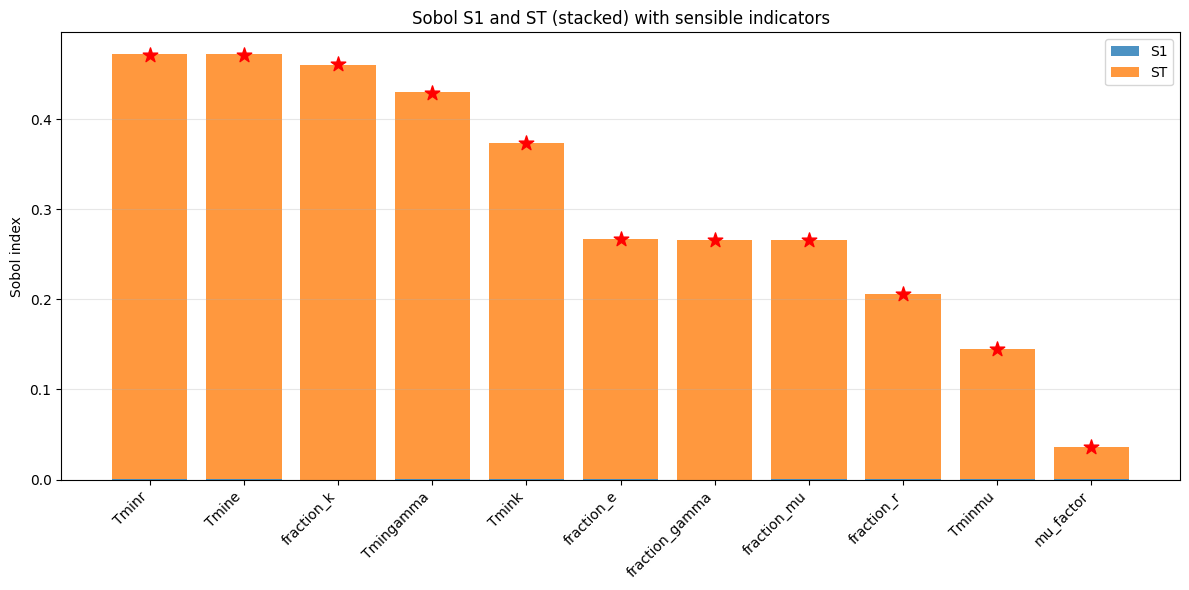

In [27]:
st = np.asarray(Si['ST'])
st = np.where(np.isnan(st), 0.0, st)
order = np.argsort(st)[::-1]
total = st.sum()
cum = 0.0
sensible_params = []
for idx in order:
    if total == 0:
        break
    cum += st[idx]
    sensible_params.append(problem['names'][idx])
    if cum / total >= 1:
        break
        
print(f"Sensible parameters: {sensible_params}")

# Plot ST and S1 stacked, highlighting sensible parameters
s1 = np.asarray(Si['S1'])
s1 = np.where(np.isnan(s1), 0.0, s1)

names = np.array(problem['names'])
sorted_names = names[order]
st_sorted = st[order]
s1_sorted = s1[order]

x = np.arange(len(sorted_names))
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x, s1_sorted, label='S1', color='tab:blue', alpha=0.8)
ax.bar(x, st_sorted, bottom=s1_sorted, label='ST', color='tab:orange', alpha=0.8)

sensible_set = set(sensible_params)
for i, name in enumerate(sorted_names):
    if name in sensible_set:
        ax.scatter(i, st_sorted[i], marker='*', s=120, color='red', zorder=3)

ax.set_xticks(x)
ax.set_xticklabels(sorted_names, rotation=45, ha='right')
ax.set_ylabel('Sobol index')
ax.set_title('Sobol S1 and ST (stacked) with sensible indicators')
#ax.set_yscale('log')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Optimization
params = create_params(sensible_params)

In [28]:
CATEGORIES = ['park', 'house', 'street']
final_results = {}

for category in CATEGORIES:
    print(f"\n--- Processing Category: {category} ---")
    
    best_result = None
    best_chisqr = np.inf
    
    n_runs = 10
    print(f"Starting optimization ({n_runs} runs)...")
    
    for i in range(n_runs):
        out = lmfit.minimize(
            objective_function,
            params,
            args=(category,),
            method='differential_evolution',
            maxiter=10000,
            popsize=100,
            seed=i,
            tol=1e-7
        )
        
        out_final = lmfit.minimize(
            objective_function,
            out.params,
            args=(category,),
            method='leastsq'
        )
        
        print(f"Run {i}: Chi2 = {out_final.chisqr:.4f}")
        if out_final.chisqr < best_chisqr:
            best_chisqr = out_final.chisqr
            best_result = out_final
    
    print(f"Best Chi2 for {category}: {best_chisqr:.4f}")
    
    # Store results
    cat_params = {}
    for name in best_result.params:
        cat_params[name] = best_result.params[name].value
        
    final_results[category] = cat_params


--- Processing Category: park ---
Starting optimization (10 runs)...


/opt/homebrew/lib/python3.13/site-packages/lmfit/minimizer.py:447: RuntimeWarning: ignoring `maxiter` argument to `Minimizer()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, 'Minimizer'),


Run 0: Chi2 = 42.9682
Run 1: Chi2 = 42.9682
Run 2: Chi2 = 42.9682
Run 3: Chi2 = 10.7040
Run 4: Chi2 = 42.9682
Run 5: Chi2 = 42.9682
Run 6: Chi2 = 42.9682
Run 7: Chi2 = 42.9682
Run 8: Chi2 = 42.9682
Run 9: Chi2 = 42.9682
Best Chi2 for park: 10.7040

--- Processing Category: house ---
Starting optimization (10 runs)...
Run 0: Chi2 = 43.0353
Run 1: Chi2 = 43.0353
Run 2: Chi2 = 43.0353
Run 3: Chi2 = 43.0353
Run 4: Chi2 = 11.1205
Run 5: Chi2 = 43.0353
Run 6: Chi2 = 11.1205
Run 7: Chi2 = 43.0353
Run 8: Chi2 = 43.0353
Run 9: Chi2 = 28.4899
Best Chi2 for house: 11.1205

--- Processing Category: street ---
Starting optimization (10 runs)...
Run 0: Chi2 = 9.1855
Run 1: Chi2 = 9.2807
Run 2: Chi2 = 35.9290
Run 3: Chi2 = 35.9290
Run 4: Chi2 = 35.9290
Run 5: Chi2 = 35.9290
Run 6: Chi2 = 35.9290
Run 7: Chi2 = 10.5957
Run 8: Chi2 = 35.9290
Run 9: Chi2 = 10.5955
Best Chi2 for street: 9.1855


In [29]:
fitted_params = final_results
fitted_params

{'park': {'Tminmu': np.float64(25.677659830353402),
  'fraction_mu': np.float64(0.16629659729114232),
  'Tmingamma': np.float64(24.447975488808822),
  'fraction_gamma': np.float64(0.19541088310791865),
  'Tminr': np.float64(26.543288055494862),
  'fraction_r': np.float64(0.10000004831277169),
  'Tmink': np.float64(32.687844824837185),
  'fraction_k': np.float64(0.9999999996530251),
  'Tmine': np.float64(21.33886029839591),
  'fraction_e': np.float64(0.2126985171820405),
  'mu_factor': np.float64(9.998708095955887),
  'Tmaxmu': np.float64(28.059416265811873),
  'Tmaxgamma': np.float64(27.487010332656688),
  'Tmaxr': np.float64(27.88895990007643),
  'Tmaxk': np.float64(39.999999997462865),
  'Tmaxe': np.float64(25.308057041854006)},
 'house': {'Tminmu': np.float64(15.790919011735873),
  'fraction_mu': np.float64(0.40103942715630914),
  'Tmingamma': np.float64(25.17111813551628),
  'fraction_gamma': np.float64(0.999999999986121),
  'Tminr': np.float64(24.804691109075844),
  'fraction_r': 

## 5. Parameters

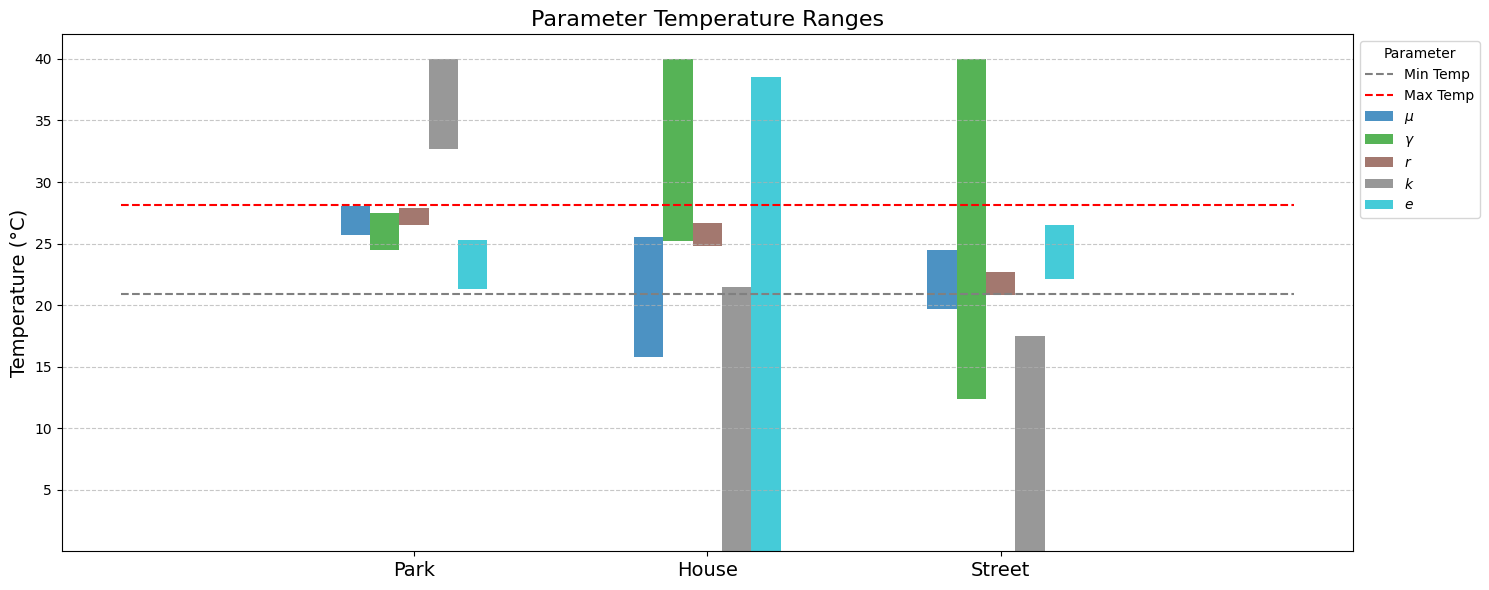

mu_factor[park] = 9.9987
mu_factor[house] = 1.0000
mu_factor[street] = 10.0000


In [30]:

parameters_map = {
    'mu': '$\\mu$',
    'gamma': '$\\gamma$', 
    'r': '$r$', 
    'k': '$k$', 
    'e': '$e$'
}
categories_keys = ['park', 'house', 'street']
categories_labels = ['Park', 'House', 'Street']

fig, ax = plt.subplots(figsize=(15, 6))

bar_width = 0.1
index = np.arange(len(categories_keys))
opacity = 0.8

ax.hlines(np.min(full_data["Temperature"]), -1, len(categories_keys), colors='gray', linestyles='dashed', label='Min Temp')
ax.hlines(np.max(full_data["Temperature"]), -1, len(categories_keys), colors='red', linestyles='dashed', label='Max Temp')
# Colors for parameters
colors = plt.cm.tab10(np.linspace(0, 1, len(parameters_map)))

for i, (param_suffix, param_label) in enumerate(parameters_map.items()):
    tmin_vals = []
    heights = []
    
    for cat in categories_keys:
        if cat in final_results:
            p = final_results[cat]
            tmin_key = f'Tmin{param_suffix}'
            tmax_key = f'Tmax{param_suffix}'
            tmin = p.get(tmin_key, 0)
            tmax = p.get(tmax_key, 0)
            
            tmin_vals.append(tmin)
            heights.append(tmax - tmin)
        else:
            tmin_vals.append(0)
            heights.append(0)
            
    # x coordinates
    x = index + i * bar_width - (len(parameters_map) * bar_width / 2) + bar_width/2
    
    rects = ax.bar(x, heights, bar_width, bottom=tmin_vals,
                   alpha=opacity, color=colors[i], label=param_label) #, edgecolor='black', linewidth=1)
    
    # Optional: Add small caps or error bars if mimicking the image exactly, 
    # typically by plotting errorbar with no line, just cap.
    # But bars are good representation of range.

ax.set_ylabel('Temperature (°C)', fontsize=14)
ax.set_xticks(index)
ax.set_xticklabels(categories_labels, fontsize=14)
ax.legend(title='Parameter', bbox_to_anchor=(1.0, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Parameter Temperature Ranges', fontsize=16)
plt.tight_layout()
plt.show()

for cat in categories_keys:
    print("mu_factor[" + cat + "] = " + f"{final_results[cat]['mu_factor']:.4f}")

## 6. Testing in each category

In [31]:
def compute_equilibria(params, days):
    Tminmu, Tmaxmu = params["Tminmu"], params["Tmaxmu"]
    Tmingamma, Tmaxgamma = params["Tmingamma"], params["Tmaxgamma"]
    Tminr, Tmaxr = params["Tminr"], params["Tmaxr"]
    Tmink, Tmaxk = params["Tmink"], params["Tmaxk"]
    Tmine, Tmaxe = params["Tmine"], params["Tmaxe"]
    mu_factor = params["mu_factor"]
    
    mu10, mu20, mu30 = 0.1170, 0.025, 0.01
    gamma0, r0, k0, e0 = 0.5596, 34, 89000, 0.24
    
    ovt_values, adt_values = [], []
    
    for t in days:
        T, P = temperature(t), pluviosity(t)
        
        Mmu, Dmu = (Tminmu + Tmaxmu) / 2, abs(Tmaxmu - Tminmu) / 2
        Mgamma, Dgamma = (Tmingamma + Tmaxgamma) / 2, abs(Tmaxgamma - Tmingamma) / 2
        Mr, Dr = (Tminr + Tmaxr) / 2, abs(Tmaxr - Tminr) / 2
        Mk, Dk = (Tmink + Tmaxk) / 2, abs(Tmaxk - Tmink) / 2
        Me, De = (Tmine + Tmaxe) / 2, abs(Tmaxe - Tmine) / 2
        
        mu1 = (mu_factor - (mu_factor-1)*plateau(Dmu, Mmu, T))*mu10
        mu2 = (mu_factor - (mu_factor-1)*plateau(Dmu, Mmu, T))*mu20
        mu3 = (mu_factor - (mu_factor-1)*plateau(Dmu, Mmu, T))*mu30
        gamma = normal(Dgamma, Mgamma, T) * gamma0
        r = phi(P) * normal(Dr, Mr, T) * r0
        k = phi(P) * normal(Dk, Mk, T) * k0
        e = e0 * normal(De, Me, T) * phi(P)
        
        denom = mu1 * (mu2 + gamma) * (mu3 + e)
        Q0 = (gamma * e * r) / denom if denom != 0 else 0
        
        if Q0 > 1:
            eqADT = k * (gamma / mu1) * (1 - 1 / Q0)
            denom2 = mu1 * (mu3 + e)
            eqOVT = k * (gamma * r) / denom2 * (1 - 1 / Q0) if denom2 != 0 else 0
        else:
            eqADT, eqOVT = 0, 0
        
        ovt_values.append(eqOVT)
        adt_values.append(eqADT)
    
    return np.array(ovt_values), np.array(adt_values)

In [32]:
pred_park_ovt, pred_park_adt = compute_equilibria(fitted_params['park'], days)
pred_house_ovt, pred_house_adt = compute_equilibria(fitted_params['house'], days)
pred_street_ovt, pred_street_adt = compute_equilibria(fitted_params['street'], days)
print('Predictions computed.')

Predictions computed.


In [33]:
def safe_pearsonr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return pearsonr(x, y)[0]

obs_park_ovt = full_data['OVT_park']
obs_park_adt = full_data['ADT_park']
obs_house_ovt = full_data['OVT_house']
obs_house_adt = full_data['ADT_house']
obs_street_ovt = full_data['OVT_street']
obs_street_adt = full_data['ADT_street']

corr_park_ovt = safe_pearsonr(obs_park_ovt, pred_park_ovt)
corr_park_adt = safe_pearsonr(obs_park_adt, pred_park_adt)
corr_house_ovt = safe_pearsonr(obs_house_ovt, pred_house_ovt)
corr_house_adt = safe_pearsonr(obs_house_adt, pred_house_adt)
corr_street_ovt = safe_pearsonr(obs_street_ovt, pred_street_ovt)
corr_street_adt = safe_pearsonr(obs_street_adt, pred_street_adt)

print('Correlations by Terrain Type:')
print(f'  Park OVT: {corr_park_ovt:.3f}, ADT: {corr_park_adt:.3f}')
print(f'  House OVT: {corr_house_ovt:.3f}, ADT: {corr_house_adt:.3f}')
print(f'  Street OVT: {corr_street_ovt:.3f}, ADT: {corr_street_adt:.3f}')

Correlations by Terrain Type:
  Park OVT: 0.699, ADT: 0.903
  House OVT: 0.747, ADT: 0.847
  Street OVT: 0.930, ADT: 0.647


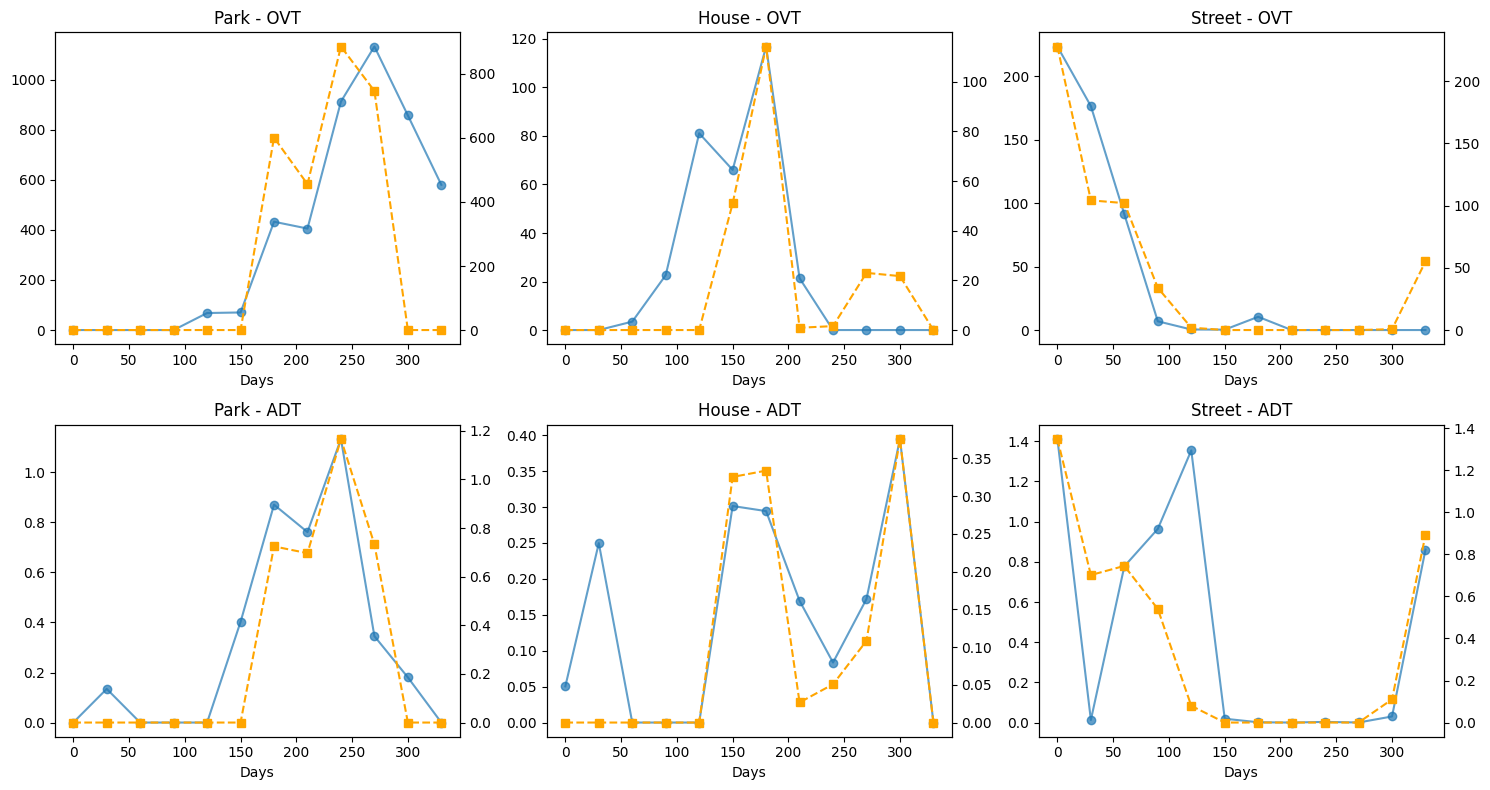

In [34]:
# Plot terrain comparisons
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

terrains = ['Park', 'House', 'Street']
obs_ovt = [obs_park_ovt, obs_house_ovt, obs_street_ovt]
pred_ovt = [pred_park_ovt, pred_house_ovt, pred_street_ovt]
obs_adt = [obs_park_adt, obs_house_adt, obs_street_adt]
pred_adt = [pred_park_adt, pred_house_adt, pred_street_adt]

for i, terrain in enumerate(terrains):
    ax = axes[0, i]
    ax.plot(days, obs_ovt[i], 'o-', label='Observed', alpha=0.7)
    ax2 = ax.twinx()
    ax2.plot(days, pred_ovt[i], 's--', color='orange', label='Predicted')
    ax.set_title(f'{terrain} - OVT')
    ax.set_xlabel('Days')
    
    ax = axes[1, i]
    ax.plot(days, obs_adt[i], 'o-', label='Observed', alpha=0.7)
    ax2 = ax.twinx()
    ax2.plot(days, pred_adt[i], 's--', color='orange', label='Predicted')
    ax.set_title(f'{terrain} - ADT')
    ax.set_xlabel('Days')

plt.tight_layout()
plt.show()

## 7. Neighorhood reconstruction

In [35]:
# Load observed neighborhood data from original CSV
df_orig = pd.read_csv('../data/NovaIguacu.csv')

# Handle missing values
CabucuOVT = df_orig['OVT_Cabuçu'].ffill().bfill()
MoquetaOVT = df_orig['OVT_Moqueta'].ffill().bfill()
CeramicaOVT = df_orig['OVT_Ceramica'].ffill().bfill()

# Handle completely empty columns by using average of others
if CabucuOVT.isnull().all():
    CabucuOVT = (MoquetaOVT + CeramicaOVT) / 2
if MoquetaOVT.isnull().all():
    MoquetaOVT = (CabucuOVT + CeramicaOVT) / 2
if CeramicaOVT.isnull().all():
    CeramicaOVT = (CabucuOVT + MoquetaOVT) / 2

CabucuOVT = CabucuOVT.values
MoquetaOVT = MoquetaOVT.values
CeramicaOVT = CeramicaOVT.values

CabucuADT = df_orig['ADT_Cabuçu'].ffill().bfill().values
MoquetaADT = df_orig['ADT_Moqueta'].ffill().bfill().values
CeramicaADT = df_orig['ADT_Ceramica'].ffill().bfill().values

print(f"Loaded observed data for {len(CabucuOVT)} time points.")

Loaded observed data for 12 time points.


In [36]:
# Load proportions from terrain analysis
# These should match what was computed in dataPreparation.ipynb
from PIL import Image

def isGreen(rgb):
    r, g, b = rgb
    if g > r and g > b and g > 50: return True
    if g > 40 and g > r * 0.9 and g > b * 1.1: return True
    return False

def isStreet(rgb_map):
    r, g, b = rgb_map
    if b > r and 200 < b < 245 and 200 < g < 235:
        if abs(r - g) < 30: return True
    return False

def count_terrain(roadmap_path, satellite_path):
    roadmap = Image.open(roadmap_path).convert('RGB')
    satellite = Image.open(satellite_path).convert('RGB')
    width, height = roadmap.size
    water, parks, streets, houses = 0, 0, 0, 0
    for x in range(0, width, 3):
        for y in range(0, height, 3):
            pm, ps = roadmap.getpixel((x, y))[:3], satellite.getpixel((x, y))[:3]
            if isStreet(pm): streets += 1
            elif isGreen(ps): parks += 1
            else: houses += 1
    return [0, parks, streets, houses]

neighborhoods = ['Cabucu', 'Moqueta', 'Ceramica']
map_base_path = '../maps/NovaIguacu_RJ'

proportions_raw = []
for n in neighborhoods:
    counts = count_terrain(f'{map_base_path}/{n}/roadmap.png', f'{map_base_path}/{n}/satellite.png')
    proportions_raw.append(counts)
    print(f'  {n}: {counts}')

proportions = [np.array(c) / sum(c) for c in proportions_raw]
matProporcoes = np.array(proportions)

print("\nProportions matrix [water, parks, streets, houses]:")
print(matProporcoes)

  Cabucu: [0, 22095, 24422, 135812]
  Moqueta: [0, 15480, 22603, 144246]
  Ceramica: [0, 7778, 31218, 143333]

Proportions matrix [water, parks, streets, houses]:
[[0.         0.12118204 0.13394468 0.74487328]
 [0.         0.08490147 0.12396821 0.79113032]
 [0.         0.04265915 0.17121796 0.78612289]]


In [37]:
# Combine terrain predictions using proportion matrix
n_times = len(days)

pred_cabucu_ovt = np.zeros(n_times)
pred_moqueta_ovt = np.zeros(n_times)
pred_ceramica_ovt = np.zeros(n_times)

pred_cabucu_adt = np.zeros(n_times)
pred_moqueta_adt = np.zeros(n_times)
pred_ceramica_adt = np.zeros(n_times)

for t in range(n_times):
    # OVT predictions [water, park, street, house]
    terrain_ovt = [0, pred_park_ovt[t], pred_street_ovt[t], pred_house_ovt[t]]
    combined_ovt = matProporcoes @ terrain_ovt
    pred_cabucu_ovt[t] = combined_ovt[0]
    pred_moqueta_ovt[t] = combined_ovt[1]
    pred_ceramica_ovt[t] = combined_ovt[2]
    
    # ADT predictions
    terrain_adt = [0, pred_park_adt[t], pred_street_adt[t], pred_house_adt[t]]
    combined_adt = matProporcoes @ terrain_adt
    pred_cabucu_adt[t] = combined_adt[0]
    pred_moqueta_adt[t] = combined_adt[1]
    pred_ceramica_adt[t] = combined_adt[2]

print("Combined predictions computed for all neighborhoods.")

Combined predictions computed for all neighborhoods.


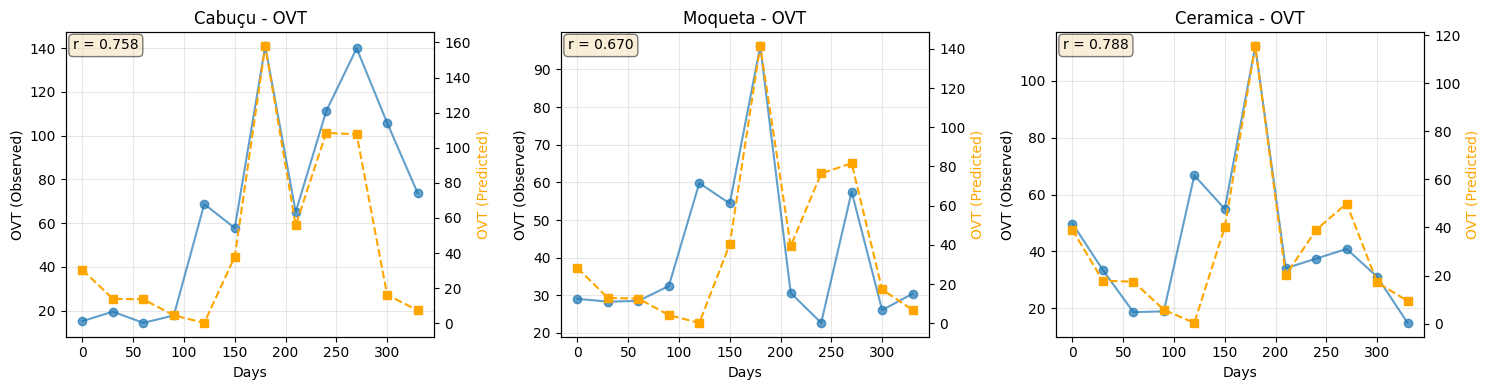

In [38]:
# Plot neighborhood-level OVT comparisons
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

neigh_names = ['Cabuçu', 'Moqueta', 'Ceramica']
obs_ovt_list = [CabucuOVT, MoquetaOVT, CeramicaOVT]
pred_ovt_list = [pred_cabucu_ovt, pred_moqueta_ovt, pred_ceramica_ovt]

corr_neigh_ovt = []
for ax1, name, obs, pred in zip(axes, neigh_names, obs_ovt_list, pred_ovt_list):
    ax1.plot(days, obs, 'o-', label='Observed', alpha=0.7)
    ax1.set_xlabel('Days')
    ax1.set_ylabel('OVT (Observed)')
    ax1.grid(True, alpha=0.3)
    
    ax2 = ax1.twinx()
    ax2.plot(days, pred, 's--', color='orange', label='Predicted')
    ax2.set_ylabel('OVT (Predicted)', color='orange')
    
    ax1.set_title(f'{name} - OVT')
    corr = safe_pearsonr(obs, pred)
    corr_neigh_ovt.append(corr)
    ax1.text(0.02, 0.98, f'r = {corr:.3f}', transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

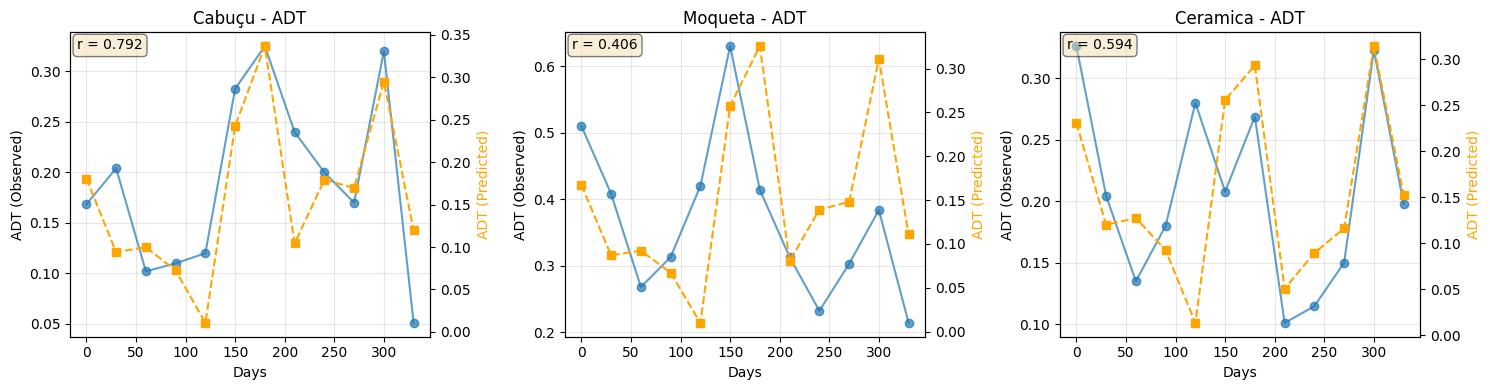

In [39]:
# Plot neighborhood-level ADT comparisons
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

obs_adt_list = [CabucuADT, MoquetaADT, CeramicaADT]
pred_adt_list = [pred_cabucu_adt, pred_moqueta_adt, pred_ceramica_adt]

corr_neigh_adt = []
for ax1, name, obs, pred in zip(axes, neigh_names, obs_adt_list, pred_adt_list):
    ax1.plot(days, obs, 'o-', label='Observed', alpha=0.7)
    ax1.set_xlabel('Days')
    ax1.set_ylabel('ADT (Observed)')
    ax1.grid(True, alpha=0.3)
    
    ax2 = ax1.twinx()
    ax2.plot(days, pred, 's--', color='orange', label='Predicted')
    ax2.set_ylabel('ADT (Predicted)', color='orange')
    
    ax1.set_title(f'{name} - ADT')
    corr = safe_pearsonr(obs, pred)
    corr_neigh_adt.append(corr)
    ax1.text(0.02, 0.98, f'r = {corr:.3f}', transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

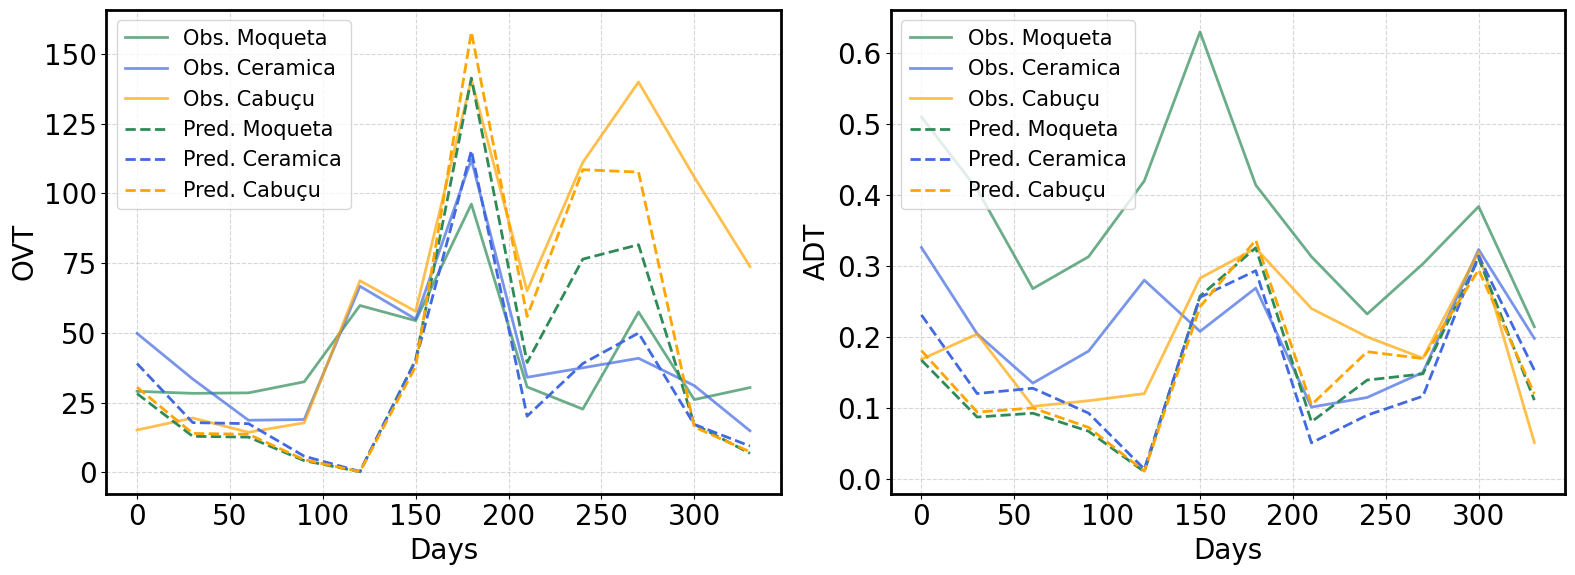

In [40]:
plt.rcParams.update({
    'font.size': 15,
    'axes.titlesize': 26,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'lines.linewidth': 2,
    'axes.linewidth': 2      # Espessura das bordas dos eixos
})

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# OVT with double y-axis
ax1 = axes[0]
# Left axis - Observed
ax1.set_xlabel('Days')
ax1.set_ylabel('OVT', color='black')
l1 = ax1.plot(days, MoquetaOVT, '-', color='seagreen', alpha=0.7, markersize=4, label='Obs. Moqueta')
l2 = ax1.plot(days, CeramicaOVT, '-', color='royalblue', alpha=0.7, markersize=4, label='Obs. Ceramica')
l3 = ax1.plot(days, CabucuOVT, '-', color='orange', alpha=0.7, markersize=4, label='Obs. Cabuçu')
ax1.tick_params(axis='y')
ax1.grid(True, linestyle='--', alpha=0.5)

# Right axis - Predicted
ax1b = ax1
ax1b.set_ylabel('OVT', color='black')
l4 = ax1b.plot(days, pred_moqueta_ovt, '--', color='seagreen', linewidth=2, label='Pred. Moqueta')
l5 = ax1b.plot(days, pred_ceramica_ovt, '--', color='royalblue', linewidth=2, label='Pred. Ceramica')
l6 = ax1b.plot(days, pred_cabucu_ovt, '--', color='orange', linewidth=2, label='Pred. Cabuçu')
ax1b.tick_params(axis='y', labelcolor='black')

lines = l1 + l2 + l3 + l4 + l5 + l6
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=15)
#ax1.set_title('OVT - All Neighborhoods')

# ADT with double y-axis
ax2 = axes[1]
# Left axis - Observed
ax2.set_xlabel('Days')
ax2.set_ylabel('ADT', color='black')
l1 = ax2.plot(days, MoquetaADT, '-', color='seagreen', alpha=0.7, markersize=4, label='Obs. Moqueta')
l2 = ax2.plot(days, CeramicaADT, '-', color='royalblue', alpha=0.7, markersize=4, label='Obs. Ceramica')
l3 = ax2.plot(days, CabucuADT, '-', color='orange', alpha=0.7, markersize=4, label='Obs. Cabuçu')
ax2.tick_params(axis='y')
ax2.grid(True, linestyle='--', alpha=0.5)

# Right axis - Predicted
ax2b = ax2
ax2b.set_ylabel('ADT', color='black')
l4 = ax2b.plot(days, pred_moqueta_adt, '--', color='seagreen', linewidth=2, label='Pred. Moqueta')
l5 = ax2b.plot(days, pred_ceramica_adt, '--', color='royalblue', linewidth=2, label='Pred. Ceramica')
l6 = ax2b.plot(days, pred_cabucu_adt, '--', color='orange', linewidth=2, label='Pred. Cabuçu')
ax2b.tick_params(axis='y', labelcolor='black')

lines = l1 + l2 + l3 + l4 + l5 + l6
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='upper left', fontsize=15)
#ax2.set_title('ADT - All Neighborhoods')

plt.tight_layout()
plt.show()

In [41]:
print("=" * 60)
print("SUMMARY: Pearson Correlations")
print("=" * 60)

print("\n--- By Terrain Type ---")
print(f"{'Terrain':<10} {'OVT':>10} {'ADT':>10}")
print("-" * 30)
print(f"{'Park':<10} {corr_park_ovt:>10.3f} {corr_park_adt:>10.3f}")
print(f"{'House':<10} {corr_house_ovt:>10.3f} {corr_house_adt:>10.3f}")
print(f"{'Street':<10} {corr_street_ovt:>10.3f} {corr_street_adt:>10.3f}")

print("\n--- By Neighborhood (Combined) ---")
print(f"{'Neighborhood':<15} {'OVT':>10} {'ADT':>10}")
print("-" * 35)
for name, c_ovt, c_adt in zip(neigh_names, corr_neigh_ovt, corr_neigh_adt):
    print(f"{name:<15} {c_ovt:>10.3f} {c_adt:>10.3f}")

print("\n--- Overall Averages ---")
avg_terrain_ovt = np.nanmean([corr_park_ovt, corr_house_ovt, corr_street_ovt])
avg_terrain_adt = np.nanmean([corr_park_adt, corr_house_adt, corr_street_adt])
avg_neigh_ovt = np.nanmean(corr_neigh_ovt)
avg_neigh_adt = np.nanmean(corr_neigh_adt)

print(f"Avg. Terrain:     OVT = {avg_terrain_ovt:.3f}, ADT = {avg_terrain_adt:.3f}")
print(f"Avg. Neighborhood: OVT = {avg_neigh_ovt:.3f}, ADT = {avg_neigh_adt:.3f}")

SUMMARY: Pearson Correlations

--- By Terrain Type ---
Terrain           OVT        ADT
------------------------------
Park            0.699      0.903
House           0.747      0.847
Street          0.930      0.647

--- By Neighborhood (Combined) ---
Neighborhood           OVT        ADT
-----------------------------------
Cabuçu               0.758      0.792
Moqueta              0.670      0.406
Ceramica             0.788      0.594

--- Overall Averages ---
Avg. Terrain:     OVT = 0.792, ADT = 0.799
Avg. Neighborhood: OVT = 0.739, ADT = 0.597


MAE       RMSE    sMAPE_%        R2  Spearman  \
Neighborhood Type                                                        
Cabuçu       ADT    0.047886   0.065595  40.791348  0.397823  0.657343   
             OVT   28.340251  40.182192  69.077014  0.207630  0.559441   
Ceramica     ADT    0.064635   0.093129  42.585802 -0.579439  0.566434   
             OVT   14.103813  21.753040  50.688020  0.275085  0.545455   
Moqueta      ADT    0.217889   0.246652  89.889096 -3.625499  0.234676   
             OVT   24.852296  30.631219  75.868679 -1.182645  0.118881   

                    Kendall       NSE       CCC  
Neighborhood Type                                
Cabuçu       ADT   0.484848  0.397823  0.739249  
             OVT   0.454545  0.207630  0.675217  
Ceramica     ADT   0.484848 -0.579439  0.484690  
             OVT   0.515152  0.275085  0.714618  
Moqueta      ADT   0.137409 -3.625499  0.127237  
             OVT   0.060606 -1.182645  0.543382

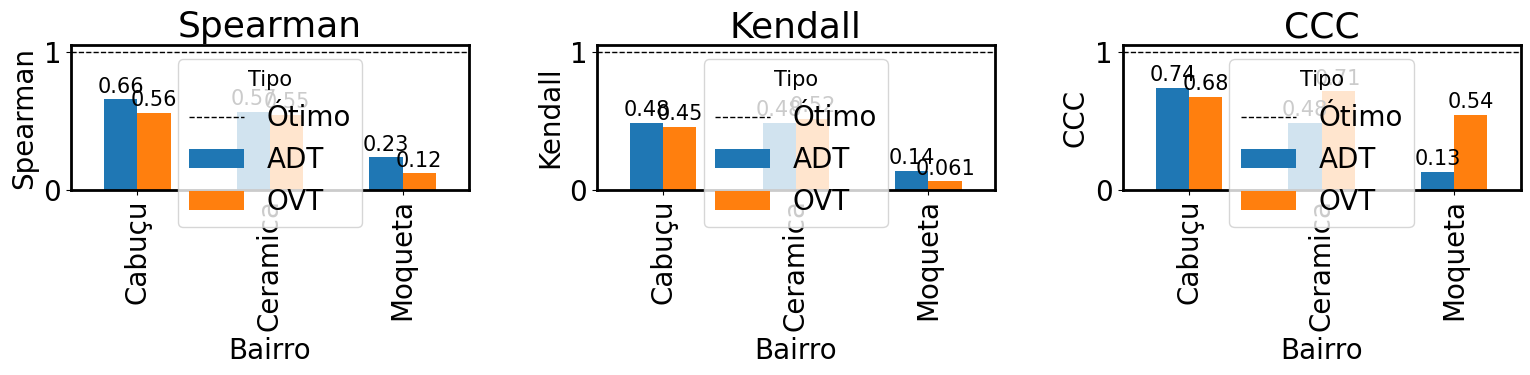

In [42]:
# Summary extra: métricas adicionais (apenas por bairro) + gráficos
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, kendalltau
import matplotlib.pyplot as plt

def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    if y_true.size == 0:
        return {}
    err = y_pred - y_true
    mae = np.mean(np.abs(err))
    rmse = np.sqrt(np.mean(err**2))
    smape = np.mean(2 * np.abs(err) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100
    ss_res = np.sum(err**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
    spear = spearmanr(y_true, y_pred).correlation if y_true.size > 1 else np.nan
    kend = kendalltau(y_true, y_pred).correlation if y_true.size > 1 else np.nan
    nse = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    cov = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    denom = var_true + var_pred + (mean_true - mean_pred) ** 2
    ccc = (2 * cov) / denom if denom != 0 else np.nan
    return {
        "MAE": mae,
        "RMSE": rmse,
        "sMAPE_%": smape,
        "R2": r2,
        "Spearman": spear,
        "Kendall": kend,
        "NSE": nse,
        "CCC": ccc,
    }

# Montar pares apenas por bairro
rows = []
if 'obs_ovt_list' in globals() and 'pred_ovt_list' in globals() and 'neigh_names' in globals():
    for name, obs, pred in zip(neigh_names, obs_ovt_list, pred_ovt_list):
        m = compute_metrics(obs, pred)
        if m:
            m.update({"Neighborhood": name, "Type": "OVT"})
            rows.append(m)
if 'obs_adt_list' in globals() and 'pred_adt_list' in globals() and 'neigh_names' in globals():
    for name, obs, pred in zip(neigh_names, obs_adt_list, pred_adt_list):
        m = compute_metrics(obs, pred)
        if m:
            m.update({"Neighborhood": name, "Type": "ADT"})
            rows.append(m)

summary = pd.DataFrame(rows)
if summary.empty:
    print("Não foi possível gerar o summary por bairro. Verifique obs/pred por bairro.")
else:
    summary = summary.set_index(["Neighborhood", "Type"]).sort_index()
    display(summary)

    # Gráficos: um por métrica (barras OVT/ADT por bairro)
    metrics = ["Spearman", "Kendall", "CCC"]
    log_metrics = {"MAE", "RMSE" }
    optimal_lines = {
        "MAE": 0.0,
        "RMSE": 0.0,
        "sMAPE_%": 0.0,
        "R2": 1.0,
        "Spearman": 1.0,
        "Kendall": 1.0,
        "NSE": 1.0,
        "CCC": 1.0,
    }
    ncols = 3
    nrows = int(np.ceil(len(metrics) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4 * nrows))
    axes = np.array(axes).reshape(-1)

    for ax, metric in zip(axes, metrics):
        plot_df = summary[metric].unstack("Type")
        missing = plot_df.isna()
        plot_df_plot = plot_df.fillna(0)
        plot_df_plot.plot(kind="bar", ax=ax)
        ax.set_title(metric)
        ax.set_xlabel("Bairro")
        ax.set_ylabel(metric)
        ax.grid(axis='y', alpha=0.3)
        ax.legend(title="Tipo")
        if metric in log_metrics:
            ax.set_yscale("symlog", linthresh=1e-3)
        # Linha do ótimo
        ax.axhline(optimal_lines[metric], color="black", linestyle="--", linewidth=1, label="Ótimo")
        # Rótulos nas barras
        for container in ax.containers:
            ax.bar_label(container, fmt="%.2g", padding=2)
        # Marcar valores ausentes
        if missing.any().any():
            for (idx, col), is_missing in np.ndenumerate(missing.values):
                if is_missing:
                    x = idx
                    ax.text(x, 0, "NA", ha="center", va="bottom", fontsize=8, color="red")
        # Evitar legenda duplicada
        handles, labels = ax.get_legend_handles_labels()
        if len(handles) > 0:
            ax.legend(handles, labels, title="Tipo")

    # Apagar eixos vazios, se houver
    for ax in axes[len(metrics):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()